In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(8)

import numpy as np
import matplotlib.pyplot as plt

import candel
from h5py import File

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-06-18 09:20:19 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-18 09:20:19 indices of zero width: [44]
2025-06-18 09:20:19 found zero-width prior at index 44. Setting it to 0.


In [3]:
with File("/Users/rstiskalek/Projects/CANDEL/results/SH0ES/Cepheid_distances_no_redshift_r2_mu.hdf5", 'r') as f:
    samples = {key: f["samples"][key][...] for key in f["samples"].keys()}


In [4]:
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d

RA = data["RA_host"]
dec = data["dec_host"]
mu_host = samples["mu_host"]

# Assume that H0 ~ 67.4 km/s/Mpc to convert mu_host to distance in Mpc / h
h = 0.674
cosmo = FlatLambdaCDM(H0=h * 100, Om0=0.3153)
zrange = np.linspace(1e-6, 0.1, 10_000)
r_range = cosmo.comoving_distance(zrange).value
mu_range = cosmo.distmod(zrange).value

mu2r = interp1d(mu_range, r_range, kind="cubic")
r_host = mu2r(mu_host)

# Convert to comoving distance Mpc / h
r_host_mean = np.mean(r_host, axis=0) * h

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_56562/2705523137.py:13: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_56562/2705523137.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


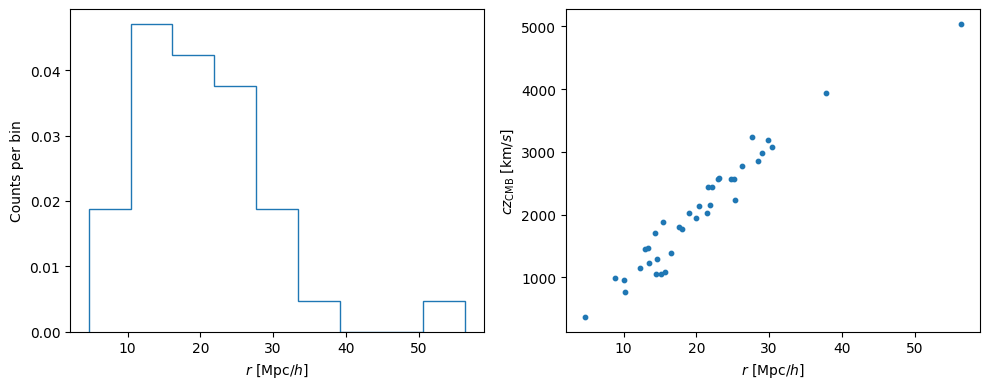

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: Histogram
axes[0].hist(r_host_mean, bins="auto", density=True, histtype='step', label="Cepheid distances")
axes[0].set_xlabel(r"$r~[\mathrm{Mpc}/h]$")
axes[0].set_ylabel("Counts per bin")

# Right: Scatter plot
axes[1].scatter(r_host_mean, data["czcmb_cepheid_host"], s=10)
axes[1].set_xlabel(r"$r~[\mathrm{Mpc}/h]$")
axes[1].set_ylabel(r"$cz_{\rm CMB}~[\mathrm{km}/s]$")

fig.tight_layout()
fig.savefig("/Users/rstiskalek/Downloads/SH0ES_hosts.png", dpi=450)
fig.show()


In [6]:
k, Pk = candel.cosmo.get_Pk_CAMB()

dDdtau = candel.cosmo.compute_dD_dtau()

C = candel.cosmo.compute_covariance_matrix(r_host_mean, RA, dec, k, Pk, dDdtau, n_jobs=10)

  0%|          | 0/703 [00:00<?, ?it/s]/Users/rstiskalek/Projects/CANDEL/venv_candel/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 703/703 [01:08<00:00, 10.31it/s]


In [8]:
np.diag(C)**0.5

array([251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247, 251.93497247, 251.93497247, 251.93497247,
       251.93497247])

In [ ]:
# Comparison when the covariance matrix was computed incorrectly.

Cold = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PV_covmat_cepheid_hosts_fiducial_WRONG_OLD.npy")

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_56562/2255041822.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


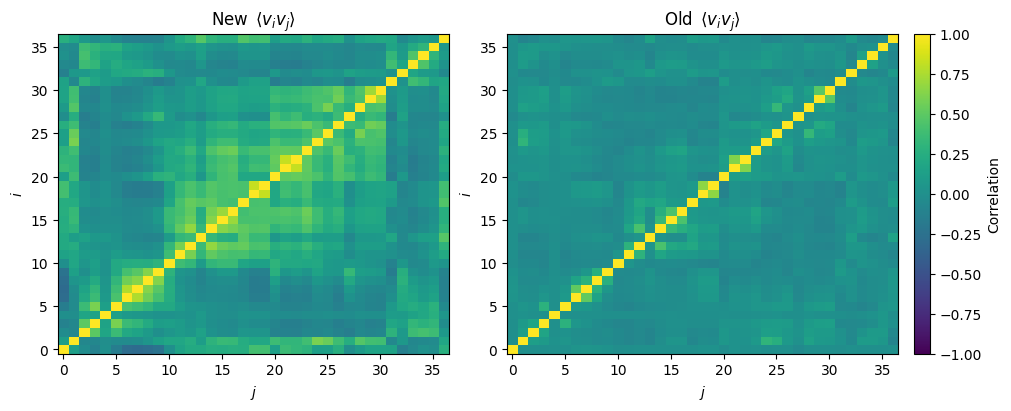

In [10]:
# Convert covariance matrices to correlation matrices
def covariance_to_correlation(C):
    std = np.sqrt(np.diag(C))
    return C / np.outer(std, std)

Corr = covariance_to_correlation(C)
Corr_old = covariance_to_correlation(Cold)

# Plot side-by-side with shared colorbar
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

vmin, vmax = -1, 1

im0 = axs[0].imshow(Corr, origin='lower', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title(r"New $\,\langle v_{i} v_{j} \rangle$")
axs[0].set_xlabel(r"$j$")
axs[0].set_ylabel(r"$i$")

im1 = axs[1].imshow(Corr_old, origin='lower', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title(r"Old $\,\langle v_{i} v_{j} \rangle$")
axs[1].set_xlabel(r"$j$")
axs[1].set_ylabel(r"$i$")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label=r"Correlation")


fig.savefig("/Users/rstiskalek/Downloads/SH0ES_covariance_comparison.png", dpi=450)
fig.show()


In [11]:
# import pecvelcov

# fname_Pk = "/Users/rstiskalek/Projects/PecVelCov.jl/data/pk_fiducial.npy"
# covmat_brute = pecvelcov.CovmatBrute(fname_Pk)
# C = covmat_brute(r, theta, phi)
# print("Finished! Computed the covariance matrix to be:")
# print(C)

In [12]:
filename_out = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PV_covmat_cepheid_hosts_fiducial.npy"
np.save(filename_out, C)

### Plot a correlation matrix

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_28027/1928279143.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


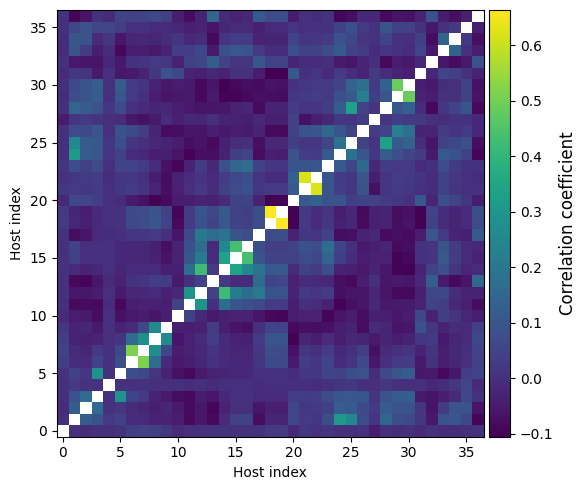

In [61]:
# Convert to correlation matrix
D = np.sqrt(np.diag(C))
corr = C / np.outer(D, D)
corr[np.isnan(corr)] = 0.0

# Exclude diagonal
np.fill_diagonal(corr, np.nan)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap="viridis", origin="lower", )

cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Correlation coefficient", fontsize=12)

ax.set_xlabel("Host index",)
ax.set_ylabel("Host index",)
ax.tick_params(axis='both',)

fig.tight_layout()
fig.savefig("/Users/rstiskalek/Downloads/pecvelcov_correlation_matrix.png", bbox_inches='tight', dpi=400)

fig.show()

In [ ]:
j10**(mu_host / 5 - 5)

array([ 6.941938 , 39.258316 , 37.5138   , 33.049038 , 84.67364  ,
       32.714405 , 19.180874 , 18.340313 , 20.14573  , 19.779596 ,
       26.167244 , 34.170277 , 32.004875 , 41.24984  , 29.769861 ,
       26.954344 , 24.72398  , 36.987434 , 21.576881 , 22.511187 ,
       21.341623 , 15.0887165, 14.904369 , 23.433018 , 34.418488 ,
       42.667706 , 22.942993 , 13.024637 , 43.23255  , 28.341019 ,
       30.429344 , 21.691563 , 45.491062 , 32.324017 , 44.594128 ,
       56.638016 , 37.7688   ], dtype=float32)

In [21]:
H0

70

In [20]:
r

array([ 485.93567, 2748.082  , 2625.966  , 2313.4326 , 5927.155  ,
       2290.0083 , 1342.6611 , 1283.8219 , 1410.201  , 1384.5718 ,
       1831.707  , 2391.9194 , 2240.3413 , 2887.4888 , 2083.8904 ,
       1886.8041 , 1730.6786 , 2589.1204 , 1510.3817 , 1575.7831 ,
       1493.9136 , 1056.2102 , 1043.3059 , 1640.3113 , 2409.2942 ,
       2986.7395 , 1606.0095 ,  911.7246 , 3026.2786 , 1983.8713 ,
       2130.0542 , 1518.4094 , 3184.3743 , 2262.6812 , 3121.5889 ,
       3964.6611 , 2643.816  ], dtype=float32)

In [18]:
mu_host

array([29.207403, 32.969658, 32.870956, 32.595795, 34.63874 , 32.573696,
       31.414343, 31.317034, 31.520916, 31.481087, 32.08879 , 32.668243,
       32.52608 , 33.07711 , 32.368885, 32.153145, 31.965591, 32.84027 ,
       31.669943, 31.761992, 31.646137, 30.893261, 30.866568, 31.84914 ,
       32.68396 , 33.150497, 31.80325 , 30.573828, 33.179054, 32.262077,
       32.416462, 31.681454, 33.28963 , 32.547626, 33.246387, 33.76554 ,
       32.885666], dtype=float32)